In [1]:
import numpy as np
import pandas as pd
#import arviz as az
import tensorrt
import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt

import collections.abc
collections.Iterable = collections.abc.Iterable
import daft
from causalgraphicalmodels import CausalGraphicalModel

tfd = tfp.distributions

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

2023-05-10 16:08:42.656377: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-10 16:08:44.383161: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-10 16:08:44.383230: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0e:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-10 16:08:44.399117: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0d:00.0/numa_node
Your kernel may have been bu

Num GPUs Available:  2
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


# Preparing data

In [2]:
with open('./data/WaffleDivorce.csv', 'r') as f:
  df = pd.read_csv(f, sep = ';')
Divorce = df.Divorce
Marriage = df.Marriage
MedianAgeMarriage = df.MedianAgeMarriage

D = (Divorce - Divorce.mean())/Divorce.std() #standardized
M = (Marriage - Marriage.mean())/Marriage.std() #standardized
A = (MedianAgeMarriage - MedianAgeMarriage.mean())/MedianAgeMarriage.std() #standardized

# *Linear Regression*

2023-05-10 16:08:54.352588: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f88d009b340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-10 16:08:54.352635: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-05-10 16:08:54.352643: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (1): NVIDIA GeForce GTX 1050 Ti, Compute Capability 6.1
2023-05-10 16:08:54.357319: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-10 16:08:55.828395: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901
2023-05-10 16:08:55.937475: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


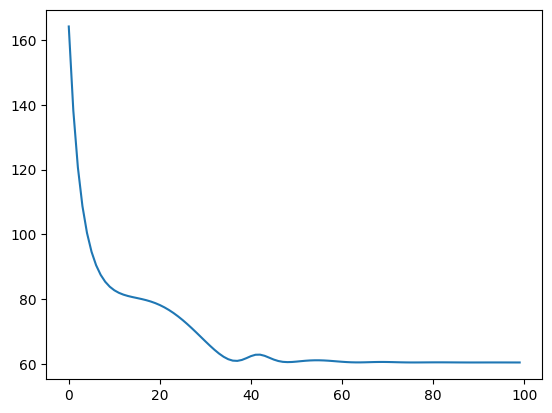

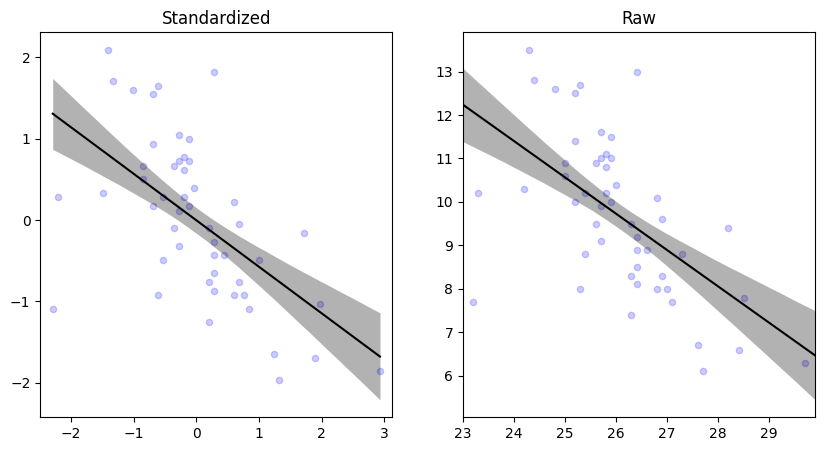

       Mean  Standard Deviation  5.5%  94.5%
Alpha -0.00                0.10 -0.16   0.15
Beta  -0.57                0.11 -0.75  -0.39
Sigma  0.79                0.08  0.66   0.91


In [3]:
dtype = tf.float64
def log_posterior_LR(alpha, beta, sigma, data):
  alpha_prior = tfd.Normal(tf.cast(0.,dtype), scale=0.2)
  beta_prior = tfd.Normal(loc=tf.cast(0.,dtype), scale=0.5)
  sigma_prior = tfd.Exponential(rate=tf.cast(1.0,dtype))
  mu = alpha + beta*A.values[:]
  Y_likelihood = tfd.Normal(loc= mu, scale= sigma)
  return (
      alpha_prior.log_prob(alpha) +\
      beta_prior.log_prob(beta) +\
      sigma_prior.log_prob(sigma) +\
      tf.reduce_sum(Y_likelihood.log_prob(data))
      )

def Mean_Quadratic(alpha, beta, sigma, data):
  losses = tfp.math.minimize(
      lambda: -log_posterior_LR(alpha, beta, sigma, data),
      optimizer=tf.optimizers.Adam(learning_rate=0.1),
      num_steps=100)
  plt.plot(losses);
  plt.show()
  return (
      alpha.numpy(),
      beta.numpy(),
      sigma.numpy()
  )

def STD_Quadratic(alpha, beta, sigma, Func):
  with tf.GradientTape() as g:
    g.watch(alpha)
    with tf.GradientTape() as gg:
      gg.watch(alpha)
      y = -Func(alpha, beta, sigma)
    dy_dalpha = gg.gradient(y, alpha)
  d2y_d2alpha = g.gradient(dy_dalpha, alpha)
  with tf.GradientTape() as g:
    g.watch(beta)
    with tf.GradientTape() as gg:
      gg.watch(beta)
      y = -Func(alpha, beta, sigma)
    dy_dbeta = gg.gradient(y, beta)
  d2y_d2beta = g.gradient(dy_dbeta, beta)
  with tf.GradientTape() as g:
    g.watch(sigma)
    with tf.GradientTape() as gg:
      gg.watch(sigma)
      y = -Func(alpha, beta, sigma)
    dy_dsigma = gg.gradient(y, sigma)
  d2y_d2sigma = g.gradient(dy_dsigma, sigma)
  return (
      ((1/d2y_d2alpha)**0.5 ).numpy(),
      ((1/d2y_d2beta)**0.5 ).numpy(),
      ((1/d2y_d2sigma)**0.5 ).numpy()
  )

log_posterior_LR_forDerivation = lambda alpha,\
                                         beta,\
                                         sigma: log_posterior_LR(alpha, beta, sigma, D)

Mean = Mean_Quadratic(tf.Variable(tf.cast(1.,dtype)),
                      tf.Variable(tf.cast(1.,dtype)),
                      tf.Variable(tf.cast(1.,dtype)),
                      D)
STD = STD_Quadratic(tf.convert_to_tensor(Mean[0]),
                    tf.convert_to_tensor(Mean[1]),
                    tf.convert_to_tensor(Mean[2]),
                    log_posterior_LR_forDerivation)

N = 10000

alpha_est = tfd.Normal(loc=Mean[0], scale=STD[0]).sample(N).numpy()
beta_est = tfd.Normal(loc=Mean[1], scale=STD[1]).sample(N).numpy()
sigma_est = tfd.Normal(loc=Mean[2], scale=STD[2]).sample(N).numpy()

d_alpha = {'Mean': pd.Series(Mean[0], index=['Alpha']),
           'Standard Deviation': pd.Series(STD[0], index=['Alpha']),
           '5.5%': pd.Series(np.percentile(alpha_est,5.5), index=['Alpha']),
           '94.5%': pd.Series(np.percentile(alpha_est,94.5), index=['Alpha'])}

d_beta = {'Mean': pd.Series(Mean[1], index=['Beta']),
           'Standard Deviation': pd.Series(STD[1], index=['Beta']),
           '5.5%': pd.Series(np.percentile(beta_est,5.5), index=['Beta']),
           '94.5%': pd.Series(np.percentile(beta_est,94.5), index=['Beta'])}

d_sigma = {'Mean': pd.Series(Mean[2], index=['Sigma']),
           'Standard Deviation': pd.Series(STD[2], index=['Sigma']),
           '5.5%': pd.Series(np.percentile(sigma_est,5.5), index=['Sigma']),
           '94.5%': pd.Series(np.percentile(sigma_est,94.5), index=['Sigma'])}

df_alpha = pd.DataFrame(d_alpha)
df_beta = pd.DataFrame(d_beta)
df_sigma = pd.DataFrame(d_sigma)
Quadratic_est = pd.concat([df_alpha,df_beta,df_sigma])

n = 50
a = np.linspace(A.min(),A.max(), n)
mu_pred = np.zeros((N,len(a)))

for i in range(len(a)):
  mu_pred[:,i] = alpha_est + beta_est*a[i]
mu_mean = np.mean(mu_pred, axis= 0)

mu_PI_89 = np.percentile(mu_pred, [5.5,94.5], axis= 0)

fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].set_xlim([A.min()-0.2,A.max()+0.2])
ax[0].set_title("Standardized")
ax[0].scatter(A, D, s=20, alpha=0.2, facecolors='b', edgecolors = 'b', marker = "o")
ax[0].plot(a, mu_mean, '-k')
ax[0].fill_between(a, mu_PI_89[0,:], mu_PI_89[1,:], alpha=0.3, linewidth=0, color = 'k')

n = 50
a = np.linspace(MedianAgeMarriage.min()-0.2,MedianAgeMarriage.max()+0.2, n)
mu_pred_raw = np.zeros((N,len(a)))

Alpha_raw = alpha_est*Divorce.std() + Divorce.mean()  \
  - (beta_est*MedianAgeMarriage.mean()*Divorce.std())/MedianAgeMarriage.std()
Beta_raw = (beta_est*Divorce.std())/MedianAgeMarriage.std()
for i in range(len(a)):
  mu_pred_raw[:,i] = Alpha_raw + Beta_raw*a[i]
mu_mean_raw = np.mean(mu_pred_raw, axis= 0)

mu_PI_89 = np.percentile(mu_pred_raw, [5.5,94.5], axis= 0)

ax[1].set_xlim([a.min(),a.max()])
ax[1].set_title("Raw")
ax[1].scatter(MedianAgeMarriage, Divorce, s=20, alpha=0.2, facecolors='b', edgecolors = 'b', marker = "o")
ax[1].plot(a, mu_mean_raw, '-k')
ax[1].fill_between(a, mu_PI_89[0,:], mu_PI_89[1,:], alpha=0.3, linewidth=0, color = 'k')
plt.show()

print(np.round(Quadratic_est, 2))

In [4]:
DMA_dag2 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M")])
all_independencies = DMA_dag2.get_all_independence_relationships()
for s in all_independencies:
    if all(
        t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
        for t in all_independencies
        if t != s
    ):
        print(s)

('M', 'D', {'A'})


In [5]:
DMA_dag1 = CausalGraphicalModel(
    nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M"), ("M", "D")]
)
all_independencies = DMA_dag1.get_all_independence_relationships()
for s in all_independencies:
    if all(
        t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
        for t in all_independencies
        if t != s
    ):
        print(s)

# *Multiple Linear Regression*

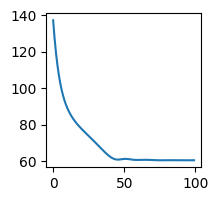

        Mean  Standard Deviation  5.5%  94.5%
Alpha   0.00                0.10 -0.15   0.16
Beta_M -0.07                0.11 -0.24   0.11
Beta_A -0.61                0.11 -0.79  -0.44
Sigma   0.79                0.08  0.66   0.92


In [6]:
dtype = tf.float64
def log_posterior_MLR(alpha, b_M, b_A, sigma, data):
  alpha_prior = tfd.Normal(tf.cast(0.,dtype), scale=0.2)
  b_M_prior = tfd.Normal(loc=tf.cast(0.,dtype), scale=0.5)
  b_A_prior = tfd.Normal(loc=tf.cast(0.,dtype), scale=0.5)
  sigma_prior = tfd.Exponential(rate=tf.cast(1.0,dtype))
  mu = alpha + b_M*M.values[:] + b_A*A.values[:]
  D_likelihood = tfd.Normal(loc= mu, scale= sigma)
  return (
      alpha_prior.log_prob(alpha) +\
      b_M_prior.log_prob(b_M) +\
      b_A_prior.log_prob(b_A) +\
      sigma_prior.log_prob(sigma) +\
      tf.reduce_sum(D_likelihood.log_prob(data))
      )

def Mean_Quadratic(alpha, b_M, b_A, sigma, data):
  losses = tfp.math.minimize(
      lambda: -log_posterior_MLR(alpha, b_M, b_A, sigma, data),
      optimizer=tf.optimizers.Adam(learning_rate=0.05),
      num_steps=100)
  plt.subplots(figsize=(2,2))
  plt.plot(losses);
  plt.show()
  return (
      alpha.numpy(),
      b_M.numpy(),
      b_A.numpy(),
      sigma.numpy()
  )

def STD_Quadratic(alpha, b_M, b_A, sigma, Func):
  dy = []
  d2y = []
  i = 0
  for Var in [alpha, b_M, b_A, sigma]:
    with tf.GradientTape() as g:
      g.watch(Var)
      with tf.GradientTape() as gg:
        gg.watch(Var)
        y = -Func(alpha, b_M, b_A, sigma)
      dy.append(gg.gradient(y, Var))
    d2y.append(g.gradient(dy[i], Var))
    i += 1
  return (
      ((1/d2y[0])**0.5 ).numpy(),
      ((1/d2y[1])**0.5 ).numpy(),
      ((1/d2y[2])**0.5 ).numpy(),
      ((1/d2y[3])**0.5 ).numpy()
  )

log_posterior_MLR_forDerivation = lambda alpha,\
                                         b_M,\
                                         b_A,\
                                         sigma: log_posterior_MLR(alpha, b_M, b_A, sigma, D)

Mean = Mean_Quadratic(tf.Variable(tf.cast(1.,dtype)),
                      tf.Variable(tf.cast(1.,dtype)),
                      tf.Variable(tf.cast(1.,dtype)),
                      tf.Variable(tf.cast(1.,dtype)),
                      D)
STD = STD_Quadratic(tf.convert_to_tensor(Mean[0]),
                    tf.convert_to_tensor(Mean[1]),
                    tf.convert_to_tensor(Mean[2]),
                    tf.convert_to_tensor(Mean[3]),
                    log_posterior_MLR_forDerivation)

N = 10000

alpha_est = tfd.Normal(loc=Mean[0], scale=STD[0]).sample(N).numpy()
b_M_est = tfd.Normal(loc=Mean[1], scale=STD[1]).sample(N).numpy()
b_A_est = tfd.Normal(loc=Mean[2], scale=STD[2]).sample(N).numpy()
sigma_est = tfd.Normal(loc=Mean[3], scale=STD[3]).sample(N).numpy()

d = {}
Heading = {"Alpha":alpha_est,"Beta_M":b_M_est,"Beta_A":b_A_est,"Sigma":sigma_est}
for i,est in enumerate(Heading.items()):
  d[i] = {'Mean': pd.Series(Mean[i], index=[est[0]]),
           'Standard Deviation': pd.Series(STD[i], index=[est[0]]),
           '5.5%': pd.Series(np.percentile(est[1],5.5), index=[est[0]]),
           '94.5%': pd.Series(np.percentile(est[1],94.5), index=[est[0]])}

Quadratic_est = pd.concat([pd.DataFrame(d[i]) for i in range(len(d))])
print(np.round(Quadratic_est, 2))

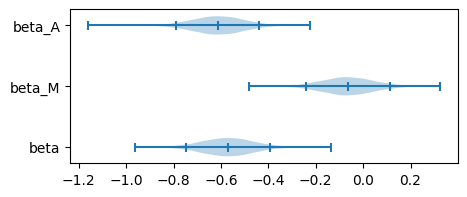

In [7]:
_,ax = plt.subplots(figsize=(5,2),sharey=True)
ax.violinplot([beta_est, b_M_est, b_A_est], points=1000, vert=False, widths=0.3,
                     showmeans=True, showextrema=True, showmedians=False, quantiles=[[0.055,0.945],[0.055,0.945],[0.055,0.945]],
                     bw_method='silverman')
labels = ['A', 'B', 'C']
ax.set_yticks(np.arange(1, len(labels) + 1), labels=['beta','beta_M','beta_A'])


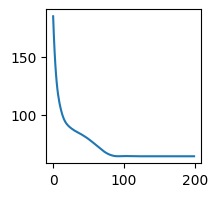

         Mean  Standard Deviation  5.5%  94.5%
Alpha   -0.94         0.09        -1.08 -0.80 
Beta_AM  0.58         0.03         0.53  0.62 
Sigma    0.68         0.07         0.58  0.79 


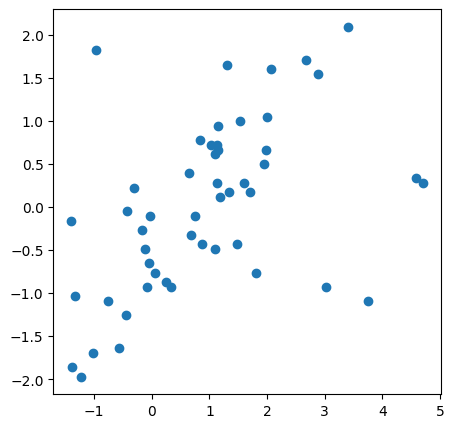

0     1.308808
1     2.882280
2     1.103569
3     3.404427
4     0.324466
5     1.992453
6    -0.572652
7     1.470306
8    -1.387263
9    -0.043215
10    1.531200
11    1.805309
12    3.755899
13   -0.084126
14    1.018231
15    1.604788
16    1.948026
17    2.066984
18    1.136246
19   -0.964775
20   -0.117746
21   -1.331772
22   -0.174866
23   -0.444516
24    0.840266
25    0.748582
26    0.675937
27    1.104513
28   -0.307462
29   -1.224563
30    1.129899
31   -1.022155
32    1.176213
33    3.020278
34   -0.023231
35    2.673525
36    0.642317
37   -0.762367
38   -1.403472
39    0.246419
40    1.143536
41    1.144480
42    1.697416
43    4.710136
44   -0.432766
45    0.878346
46    1.346888
47    1.974356
48    0.055760
49    4.582944
Name: Marriage, dtype: float64


In [8]:
dtype = tf.float64
def log_posterior_MLR(alpha, b_AM, sigma, data):
  alpha_prior = tfd.Normal(tf.cast(0.,dtype), scale=0.2)
  b_AM_prior = tfd.Normal(loc=tf.cast(0.,dtype), scale=0.5)
  sigma_prior = tfd.Exponential(rate=tf.cast(1.0,dtype))
  mu = alpha + b_AM**A.values[:]
  M_likelihood = tfd.Normal(loc= mu, scale= sigma)
  return (
      alpha_prior.log_prob(alpha) +\
      b_AM_prior.log_prob(b_AM) +\
      sigma_prior.log_prob(sigma) +\
      tf.reduce_sum(M_likelihood.log_prob(data))
      )

def Mean_Quadratic(alpha, b_AM, sigma, data):
  losses = tfp.math.minimize(
      lambda: -log_posterior_MLR(alpha, b_AM, sigma, data),
      optimizer=tf.optimizers.Adam(learning_rate=0.05),
      num_steps=200)
  plt.subplots(figsize=(2,2))
  plt.plot(losses);
  plt.show()
  return (
      alpha.numpy(),
      b_AM.numpy(),
      sigma.numpy()
  )

def STD_Quadratic(alpha, b_AM, sigma, Func):
  dy = []
  d2y = []
  i = 0
  for Var in [alpha, b_AM, sigma]:
    with tf.GradientTape() as g:
      g.watch(Var)
      with tf.GradientTape() as gg:
        gg.watch(Var)
        y = -Func(alpha, b_AM, sigma)
      dy.append(gg.gradient(y, Var))
    d2y.append(g.gradient(dy[i], Var))
    i += 1
  return (
      ((1/d2y[0])**0.5 ).numpy(),
      ((1/d2y[1])**0.5 ).numpy(),
      ((1/d2y[2])**0.5 ).numpy()
  )

log_posterior_MLR_forDerivation = lambda alpha,\
                                         b_AM,\
                                         sigma: log_posterior_MLR(alpha, b_AM, sigma, M)

Mean = Mean_Quadratic(tf.Variable(tf.cast(1.,dtype)),
                      tf.Variable(tf.cast(1.,dtype)),
                      tf.Variable(tf.cast(1.,dtype)),
                      M)
STD = STD_Quadratic(tf.convert_to_tensor(Mean[0]),
                    tf.convert_to_tensor(Mean[1]),
                    tf.convert_to_tensor(Mean[2]),
                    log_posterior_MLR_forDerivation)

N = 10000

alpha_est = tfd.Normal(loc=Mean[0], scale=STD[0]).sample(N).numpy()
b_AM_est = tfd.Normal(loc=Mean[1], scale=STD[1]).sample(N).numpy()
sigma_est = tfd.Normal(loc=Mean[2], scale=STD[2]).sample(N).numpy()

d = {}
Heading = {"Alpha":alpha_est,"Beta_AM":b_AM_est,"Sigma":sigma_est}
for i,est in enumerate(Heading.items()):
  d[i] = {'Mean': pd.Series(Mean[i], index=[est[0]]),
           'Standard Deviation': pd.Series(STD[i], index=[est[0]]),
           '5.5%': pd.Series(np.percentile(est[1],5.5), index=[est[0]]),
           '94.5%': pd.Series(np.percentile(est[1],94.5), index=[est[0]])}

Quadratic_est = pd.concat([pd.DataFrame(d[i]) for i in range(len(d))])
pd.set_option('display.colheader_justify', 'center')
print(np.round(Quadratic_est, 2))

n = 50
a = np.linspace(A.min(),A.max(), n)
mu_pred = np.zeros((N,n))

for i in range(n):
  mu_pred[:,i] = alpha_est + b_AM_est*A[i]

mu_mean = np.mean(mu_pred, axis= 0)
mu_residual = M - mu_mean

plt.subplots(figsize=(5,5))
plt.scatter(mu_residual,D);
plt.show()

print(mu_residual)

# ***Posterior Prediction***

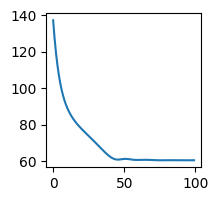

        Mean  Standard Deviation  5.5%  94.5%
Alpha   0.00         0.10        -0.15  0.16 
Beta_M -0.07         0.11        -0.24  0.11 
Beta_A -0.61         0.11        -0.79 -0.43 
Sigma   0.79         0.08         0.67  0.92 


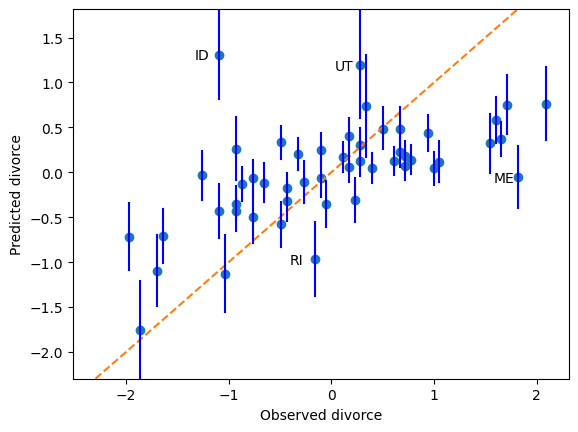

In [9]:
dtype = tf.float64
def log_posterior_MLR(alpha, b_M, b_A, sigma, data):
  alpha_prior = tfd.Normal(tf.cast(0.,dtype), scale=0.2)
  b_M_prior = tfd.Normal(loc=tf.cast(0.,dtype), scale=0.5)
  b_A_prior = tfd.Normal(loc=tf.cast(0.,dtype), scale=0.5)
  sigma_prior = tfd.Exponential(rate=tf.cast(1.0,dtype))
  mu = alpha + b_M*M.values[:] + b_A*A.values[:]
  D_likelihood = tfd.Normal(loc= mu, scale= sigma)
  return (
      alpha_prior.log_prob(alpha) +\
      b_M_prior.log_prob(b_M) +\
      b_A_prior.log_prob(b_A) +\
      sigma_prior.log_prob(sigma) +\
      tf.reduce_sum(D_likelihood.log_prob(data))
      )

def Mean_Quadratic(alpha, b_M, b_A, sigma, data):
  losses = tfp.math.minimize(
      lambda: -log_posterior_MLR(alpha, b_M, b_A, sigma, data),
      optimizer=tf.optimizers.Adam(learning_rate=0.05),
      num_steps=100)
  plt.subplots(figsize=(2,2))
  plt.plot(losses);
  plt.show()
  return (
      alpha.numpy(),
      b_M.numpy(),
      b_A.numpy(),
      sigma.numpy()
  )

def STD_Quadratic(alpha, b_M, b_A, sigma, Func):
  dy = []
  d2y = []
  i = 0
  for Var in [alpha, b_M, b_A, sigma]:
    with tf.GradientTape() as g:
      g.watch(Var)
      with tf.GradientTape() as gg:
        gg.watch(Var)
        y = -Func(alpha, b_M, b_A, sigma)
      dy.append(gg.gradient(y, Var))
    d2y.append(g.gradient(dy[i], Var))
    i += 1
  return (
      ((1/d2y[0])**0.5 ).numpy(),
      ((1/d2y[1])**0.5 ).numpy(),
      ((1/d2y[2])**0.5 ).numpy(),
      ((1/d2y[3])**0.5 ).numpy()
  )

log_posterior_MLR_forDerivation = lambda alpha,\
                                         b_M,\
                                         b_A,\
                                         sigma: log_posterior_MLR(alpha, b_M, b_A, sigma, D)

Mean = Mean_Quadratic(tf.Variable(tf.cast(1.,dtype)),
                      tf.Variable(tf.cast(1.,dtype)),
                      tf.Variable(tf.cast(1.,dtype)),
                      tf.Variable(tf.cast(1.,dtype)),
                      D)
STD = STD_Quadratic(tf.convert_to_tensor(Mean[0]),
                    tf.convert_to_tensor(Mean[1]),
                    tf.convert_to_tensor(Mean[2]),
                    tf.convert_to_tensor(Mean[3]),
                    log_posterior_MLR_forDerivation)

N = 10000

alpha_est = tfd.Normal(loc=Mean[0], scale=STD[0]).sample(N).numpy()
b_M_est = tfd.Normal(loc=Mean[1], scale=STD[1]).sample(N).numpy()
b_A_est = tfd.Normal(loc=Mean[2], scale=STD[2]).sample(N).numpy()
sigma_est = tfd.Normal(loc=Mean[3], scale=STD[3]).sample(N).numpy()

d = {}
Heading = {"Alpha":alpha_est,"Beta_M":b_M_est,"Beta_A":b_A_est,"Sigma":sigma_est}
for i,est in enumerate(Heading.items()):
  d[i] = {'Mean': pd.Series(Mean[i], index=[est[0]]),
           'Standard Deviation': pd.Series(STD[i], index=[est[0]]),
           '5.5%': pd.Series(np.percentile(est[1],5.5), index=[est[0]]),
           '94.5%': pd.Series(np.percentile(est[1],94.5), index=[est[0]])}

Quadratic_est = pd.concat([pd.DataFrame(d[i]) for i in range(len(d))])
print(np.round(Quadratic_est, 2))

n = A.shape[0]
mu_pred = np.zeros((N,n))

for i in range(n):
  mu_pred[:,i] = alpha_est + b_M_est*M[i] + b_A_est*A[i]

mu_mean = tf.reduce_mean(mu_pred, 0)
mu_PI = tfp.stats.percentile(mu_pred, q=(5.5, 94.5), axis=0).numpy()

ax = plt.subplot(
    ylim=(float(mu_PI.min()), float(mu_PI.max())),
    xlabel="Observed divorce",
    ylabel="Predicted divorce",
)
plt.plot(D, mu_mean, "o")
x = np.linspace(mu_PI.min(), mu_PI.max(), 101)
plt.plot(x, x, "--")
for i in range(D.shape[0]):
    plt.plot([D[i]] * 2, mu_PI[:, i], "b")
for i in range(df.shape[0]):
    if df.Loc[i] in ["ID", "UT", "RI", "ME"]:
        ax.annotate(
            df.Loc[i], (D[i], mu_mean[i]), xytext=(-25, -5), textcoords="offset pixels"
        )
fig = plt.gcf();

# **Counterfactual plots**

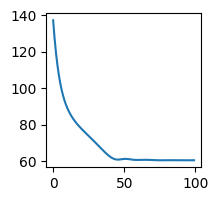

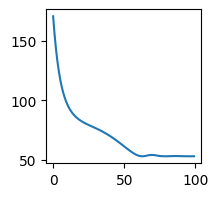

        Mean  Standard Deviation  5.5%  94.5%
Alpha   0.00         0.10        -0.15  0.16 
Beta_M -0.07         0.11        -0.24  0.12 
Beta_A -0.61         0.11        -0.80 -0.43 
Sigma   0.79         0.08         0.66  0.92 
          Mean  Standard Deviation  5.5%  94.5%
Alpha_M   0.00         0.08        -0.12  0.13 
Beta_A_M -0.69         0.09        -0.82 -0.54 
Sigma_M   0.67         0.04         0.62  0.73 


In [10]:
dtype = tf.float64
def log_posterior_D(alpha, b_M, b_A, sigma, data):
  alpha_prior = tfd.Normal(tf.cast(0.,dtype), scale=0.2)
  b_M_prior = tfd.Normal(loc=tf.cast(0.,dtype), scale=0.5)
  b_A_prior = tfd.Normal(loc=tf.cast(0.,dtype), scale=0.5)
  sigma_prior = tfd.Exponential(rate=tf.cast(1.0,dtype))
  mu = alpha + b_M*M.values[:] + b_A*A.values[:]
  D_likelihood = tfd.Normal(loc= mu, scale= sigma)
  return (
      alpha_prior.log_prob(alpha) +\
      b_M_prior.log_prob(b_M) +\
      b_A_prior.log_prob(b_A) +\
      sigma_prior.log_prob(sigma) +\
      tf.reduce_sum(D_likelihood.log_prob(data))
      )
def log_posterior_M(alpha_M, b_A_M, sigma_M, data):
  alpha_M_prior = tfd.Normal(tf.cast(0.,dtype), scale=0.2)
  b_A_M_prior = tfd.Normal(loc=tf.cast(0.,dtype), scale=0.5)
  sigma_M_prior = tfd.Exponential(rate=tf.cast(1.0,dtype))
  mu_M = alpha_M + b_A_M*A.values[:]
  M_likelihood = tfd.Normal(loc= mu_M, scale= sigma_M)
  return (
      alpha_M_prior.log_prob(alpha_M) +\
      b_A_M_prior.log_prob(b_A_M) +\
      sigma_M_prior.log_prob(sigma_M) +\
      tf.reduce_sum(M_likelihood.log_prob(data))
      )

def Mean_Quadratic_D(alpha, b_M, b_A, sigma, data):
  losses = tfp.math.minimize(
      lambda: -log_posterior_D(alpha, b_M, b_A, sigma, data),
      optimizer=tf.optimizers.Adam(learning_rate=0.05),
      num_steps=100)
  plt.subplots(figsize=(2,2))
  plt.plot(losses);
  plt.show()
  return (
      alpha.numpy(),
      b_M.numpy(),
      b_A.numpy(),
      sigma.numpy()
  )
def Mean_Quadratic_M(alpha_M, b_A_M, sigma_M, data):
  losses = tfp.math.minimize(
      lambda: -log_posterior_M(alpha_M, b_A_M, sigma_M, data),
      optimizer=tf.optimizers.Adam(learning_rate=0.05),
      num_steps=100)
  plt.subplots(figsize=(2,2))
  plt.plot(losses);
  plt.show()
  return (
      alpha_M.numpy(),
      b_A_M.numpy(),
      sigma_M.numpy()
  )

def STD_Quadratic_D(alpha, b_M, b_A, sigma, Func):
  dy = []
  d2y = []
  i = 0
  for Var in [alpha, b_M, b_A, sigma]:
    with tf.GradientTape() as g:
      g.watch(Var)
      with tf.GradientTape() as gg:
        gg.watch(Var)
        y = -Func(alpha, b_M, b_A, sigma)
      dy.append(gg.gradient(y, Var))
    d2y.append(g.gradient(dy[i], Var))
    i += 1
  return (
      ((1/d2y[0])**0.5 ).numpy(),
      ((1/d2y[1])**0.5 ).numpy(),
      ((1/d2y[2])**0.5 ).numpy(),
      ((1/d2y[3])**0.5 ).numpy()
  )
def STD_Quadratic_M(alpha_M, b_A_M, sigma_M, Func):
  dy = []
  d2y = []
  i = 0
  for Var in [alpha_M, b_A_M, sigma_M]:
    with tf.GradientTape() as g:
      g.watch(Var)
      with tf.GradientTape() as gg:
        gg.watch(Var)
        y = -Func(alpha_M, b_A_M, sigma_M)
      dy.append(gg.gradient(y, Var))
    d2y.append(g.gradient(dy[i], Var))
    i += 1
  return (
      ((1/d2y[0])**0.5 ).numpy(),
      ((1/d2y[1])**0.5 ).numpy(),
      ((1/d2y[2])**0.5 ).numpy(),
  )

log_posterior_D_forDerivation = lambda alpha,\
                                         b_M,\
                                         b_A,\
                                         sigma: log_posterior_D(alpha, b_M, b_A, sigma, D)
log_posterior_M_forDerivation = lambda alpha_M,\
                                         b_A_M,\
                                         sigma_M: log_posterior_M(alpha_M, b_A_M, sigma_M, M)

Mean_D = Mean_Quadratic_D(tf.Variable(tf.cast(1.,dtype)),
                      tf.Variable(tf.cast(1.,dtype)),
                      tf.Variable(tf.cast(1.,dtype)),
                      tf.Variable(tf.cast(1.,dtype)),
                      D)
Mean_M = Mean_Quadratic_M(tf.Variable(tf.cast(1.,dtype)),
                      tf.Variable(tf.cast(1.,dtype)),
                      tf.Variable(tf.cast(1.,dtype)),
                      M)
STD_D = STD_Quadratic_D(tf.convert_to_tensor(Mean[0]),
                    tf.convert_to_tensor(Mean[1]),
                    tf.convert_to_tensor(Mean[2]),
                    tf.convert_to_tensor(Mean[3]),
                    log_posterior_D_forDerivation)
STD_M = STD_Quadratic_M(tf.convert_to_tensor(Mean[0]),
                    tf.convert_to_tensor(Mean[1]),
                    tf.convert_to_tensor(Mean[2]),
                    log_posterior_M_forDerivation)

N = 1000

alpha_est = tfd.Normal(loc=Mean_D[0], scale=STD_D[0]).sample(N).numpy()
b_M_est = tfd.Normal(loc=Mean_D[1], scale=STD_D[1]).sample(N).numpy()
b_A_est = tfd.Normal(loc=Mean_D[2], scale=STD_D[2]).sample(N).numpy()
sigma_est = tfd.Normal(loc=Mean_D[3], scale=STD_D[3]).sample(N).numpy()

alpha_M_est = tfd.Normal(loc=Mean_M[0], scale=STD_M[0]).sample(N).numpy()
b_A_M_est = tfd.Normal(loc=Mean_M[1], scale=STD_M[1]).sample(N).numpy()
sigma_M_est = tfd.Normal(loc=Mean_M[2], scale=STD_M[2]).sample(N).numpy()

d = {}
Heading = {"Alpha":alpha_est,"Beta_M":b_M_est,"Beta_A":b_A_est,"Sigma":sigma_est}
for i,est in enumerate(Heading.items()):
  d[i] = {'Mean': pd.Series(Mean_D[i], index=[est[0]]),
           'Standard Deviation': pd.Series(STD_D[i], index=[est[0]]),
           '5.5%': pd.Series(np.percentile(est[1],5.5), index=[est[0]]),
           '94.5%': pd.Series(np.percentile(est[1],94.5), index=[est[0]])}

Quadratic_D_est = pd.concat([pd.DataFrame(d[i]) for i in range(len(d))])
print(np.round(Quadratic_D_est, 2))

d_M = {}
Heading = {"Alpha_M":alpha_M_est,"Beta_A_M":b_A_M_est,"Sigma_M":sigma_M_est}
for i,est in enumerate(Heading.items()):
  d_M[i] = {'Mean': pd.Series(Mean_M[i], index=[est[0]]),
           'Standard Deviation': pd.Series(STD_M[i], index=[est[0]]),
           '5.5%': pd.Series(np.percentile(est[1],5.5), index=[est[0]]),
           '94.5%': pd.Series(np.percentile(est[1],94.5), index=[est[0]])}

Quadratic_M_est = pd.concat([pd.DataFrame(d_M[i]) for i in range(len(d_M))])
print(np.round(Quadratic_M_est, 2))

n = A.shape[0]
mu_pred = np.zeros((N,n))

for i in range(n):
  mu_pred[:,i] = alpha_est + b_M_est*M[i] + b_A_est*A[i]

mu_mean = tf.reduce_mean(mu_pred, 0)
mu_PI = tfp.stats.percentile(mu_pred, q=(5.5, 94.5), axis=0).numpy()

-4.622000844246637


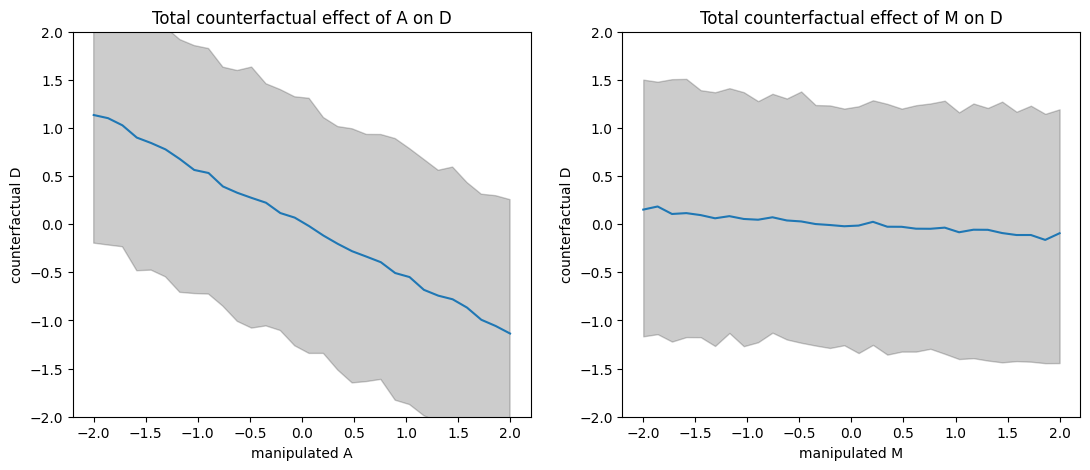

In [11]:
def Simulate_M_using_manipulated_A(a):
    mu = alpha_M_est + b_A_M_est * a
    return tfd.Normal(loc=mu, scale=sigma_M_est).sample()
def Simulate_D_using_manipulated_A(m_a):
    mu = alpha_est + b_M_est * m_a[0] + b_A_est * m_a[1]
    return tfd.Normal(loc=mu, scale=sigma_est).sample()
def Simulate_D_using_manipulated_M(m):
    mu = alpha_est + b_M_est * m
    return tfd.Normal(loc=mu, scale=sigma_est).sample()

A_seq = tf.linspace(-2.0, 2.0, num=30)
A_seq = tf.cast(A_seq, dtype=dtype)
df_A_seq = pd.DataFrame(pd.Series(data=A_seq, name="ManipulatedAge"))
ManipulatedAge = df_A_seq.ManipulatedAge

M_pred = tf.transpose(tf.vectorized_map(Simulate_M_using_manipulated_A, ManipulatedAge))
M_mean = tf.reduce_mean(M_pred, 0)
M_PI = tfp.stats.percentile(M_pred, q=(5.5, 94.5), axis=0).numpy()

D_pred = tf.transpose(tf.vectorized_map(Simulate_D_using_manipulated_A, [M_mean,ManipulatedAge]))
D_mean = tf.reduce_mean(D_pred, 0)
D_PI = tfp.stats.percentile(D_pred, q=(5.5, 94.5), axis=0).numpy()

M_seq = tf.linspace(-2.0, 2.0, num=30)
M_seq = tf.cast(A_seq, dtype=dtype)
df_M_seq = pd.DataFrame(pd.Series(data=M_seq, name="ManipulatedMarriageRate"))
ManipulatedMarriageRate = df_M_seq.ManipulatedMarriageRate
D_M_pred = tf.transpose(tf.vectorized_map(Simulate_D_using_manipulated_M, ManipulatedMarriageRate))
D_M_mean = tf.reduce_mean(D_M_pred, 0)
D_M_PI = tfp.stats.percentile(D_M_pred, q=(5.5, 94.5), axis=0).numpy()


_,ax = plt.subplots(1,2,figsize=(13,5))
ax[0].plot(ManipulatedAge, D_mean)
ax[0].set(ylim=(-2, 2), xlabel="manipulated A", ylabel="counterfactual D",title=("Total counterfactual effect of A on D"))
ax[0].fill_between(ManipulatedAge, *D_PI, color="k", alpha=0.2)

ax[1].plot(ManipulatedMarriageRate, D_M_mean)
ax[1].set(ylim=(-2, 2), xlabel="manipulated M", ylabel="counterfactual D",title=("Total counterfactual effect of M on D"))
ax[1].fill_between(ManipulatedMarriageRate, *D_M_PI, color="k", alpha=0.2)

age = (np.array([20,30])-26.1)/1.24
M_pred = tf.transpose(tf.vectorized_map(Simulate_M_using_manipulated_A, age))
mean_M = tf.reduce_mean(M_pred, 0)
D_pred = tf.transpose(tf.vectorized_map(Simulate_D_using_manipulated_A, [mean_M,age]))
D_mean = tf.reduce_mean(D_pred, 0)
print((D_mean[1] - D_mean[0]).numpy())

# **Masked relationship**

In [12]:
with open('./data/milk.csv', 'r') as f:
  df = pd.read_csv(f, sep = ';')
print(df.head())
print(df.shape)

No_NA_df = df.iloc[df[["kcal.per.g", "neocortex.perc", "mass"]].dropna(how="any", axis=0).index]
print(No_NA_df.describe())

kcal = No_NA_df["kcal.per.g"]
neocortex = No_NA_df["neocortex.perc"]
mass = No_NA_df.mass

Kdata = (kcal - kcal.mean())/kcal.std() #standardized
Ndata = (neocortex - neocortex.mean())/neocortex.std() #standardized
Mdata = (mass - mass.mean())/mass.std() #standardized

      clade          species      kcal.per.g  perc.fat  perc.protein   
0  Strepsirrhine  Eulemur fulvus     0.49       16.60       15.42     \
1  Strepsirrhine        E macaco     0.51       19.27       16.91      
2  Strepsirrhine        E mongoz     0.46       14.11       16.85      
3  Strepsirrhine   E rubriventer     0.48       14.91       13.18      
4  Strepsirrhine     Lemur catta     0.60       27.28       19.50      

   perc.lactose  mass  neocortex.perc  
0      67.98     1.95       55.16      
1      63.82     2.09         NaN      
2      69.04     2.51         NaN      
3      71.91     1.62         NaN      
4      53.22     2.19         NaN      
(29, 8)
       kcal.per.g  perc.fat   perc.protein  perc.lactose    mass      
count   17.000000  17.000000    17.000000     17.000000   17.000000  \
mean     0.657647  36.063529    16.255294     47.681176   16.637647   
std      0.172899  14.705419     5.598480     13.585261   23.582322   
min      0.460000   3.930000     7.

### **Exploring Priors**

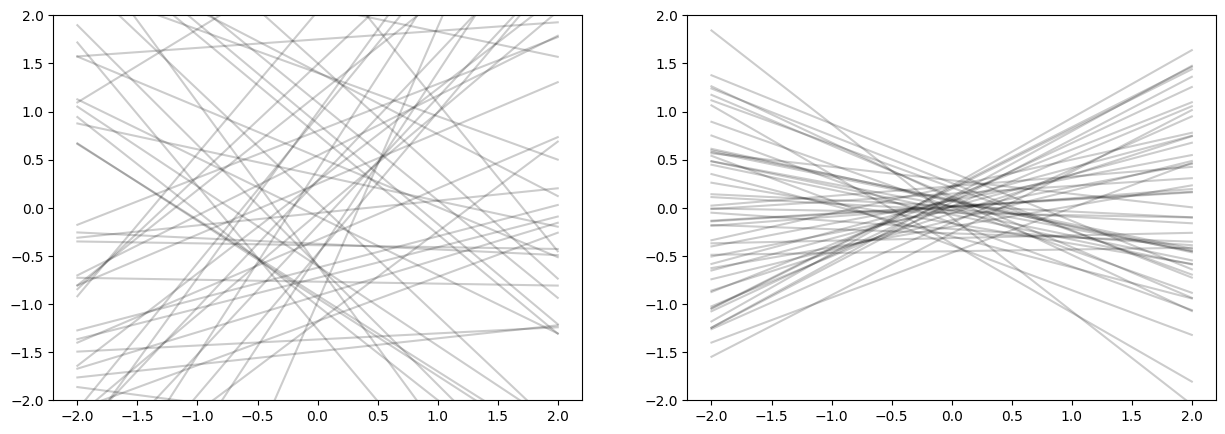

In [13]:
from matplotlib.pyplot import ylim


N = 50
alpha = tfd.Normal(loc=0.0, scale=1.0).sample(N)
bN = tfd.Normal(loc=0.0, scale=1.0).sample(N)

_,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].set(ylim=[-2,2])
ax[1].set(ylim=[-2,2])
x = np.linspace(-2, 2, 1000)
for i in range(50):
    ax[0].plot(x, alpha[i] + bN[i] * x, "k", alpha=0.2)
alpha = tfd.Normal(loc=0.0, scale=0.2).sample(N)
bN = tfd.Normal(loc=0.0, scale=0.5).sample(N)
for i in range(50):
    ax[1].plot(x, alpha[i] + bN[i] * x, "k", alpha=0.2)

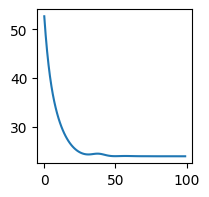

        Mean  Standard Deviation  5.5%  94.5%
Alpha  -0.00         0.15        -0.24  0.24 
Beta_N  0.13         0.21        -0.21  0.45 
Sigma   0.93         0.15         0.68  1.16 


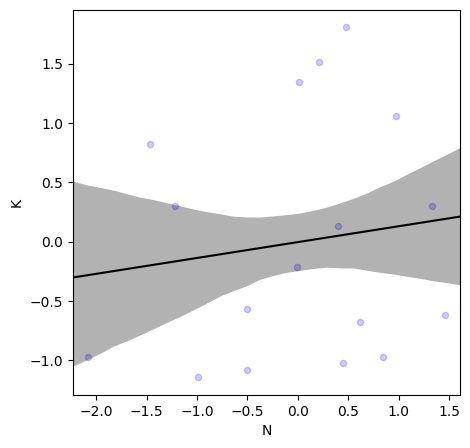

In [14]:
dtype = tf.float64
def log_posterior_K(alpha, bN, sigma, data):
  alpha_prior = tfd.Normal(tf.cast(0.,dtype), scale=0.2)
  bN_prior = tfd.Normal(loc=tf.cast(0.,dtype), scale=0.5)
  sigma_prior = tfd.Exponential(rate=tf.cast(1.0,dtype))
  mu = alpha + bN*Ndata.values[:]
  K_likelihood = tfd.Normal(loc= mu, scale= sigma)
  return (
      alpha_prior.log_prob(alpha) +\
      bN_prior.log_prob(bN) +\
      sigma_prior.log_prob(sigma) +\
      tf.reduce_sum(K_likelihood.log_prob(data))
      )
def Mean_Quadratic_K(alpha, bN, sigma, data):
  losses = tfp.math.minimize(
      lambda: -log_posterior_K(alpha, bN, sigma, data),
      optimizer=tf.optimizers.Adam(learning_rate=0.05),
      num_steps=100)
  plt.subplots(figsize=(2,2))
  plt.plot(losses);
  plt.show()
  return (
      alpha.numpy(),
      bN.numpy(),
      sigma.numpy()
  )
def STD_Quadratic_K(alpha, bN, sigma, Func):
  dy = []
  d2y = []
  i = 0
  for Var in [alpha, bN, sigma]:
    with tf.GradientTape() as g:
      g.watch(Var)
      with tf.GradientTape() as gg:
        gg.watch(Var)
        y = -Func(alpha, bN, sigma)
      dy.append(gg.gradient(y, Var))
    d2y.append(g.gradient(dy[i], Var))
    i += 1
  return (
      ((1/d2y[0])**0.5 ).numpy(),
      ((1/d2y[1])**0.5 ).numpy(),
      ((1/d2y[2])**0.5 ).numpy(),
  )
log_posterior_K_forDerivation = lambda alpha,\
                                         bN,\
                                         sigma: log_posterior_K(alpha, bN, sigma, Kdata)

Mean_K = Mean_Quadratic_K(tf.Variable(tf.cast(1.,dtype)),
                      tf.Variable(tf.cast(1.,dtype)),
                      tf.Variable(tf.cast(1.,dtype)),
                      Kdata)
STD_K = STD_Quadratic_K(tf.convert_to_tensor(Mean_K[0]),
                    tf.convert_to_tensor(Mean_K[1]),
                    tf.convert_to_tensor(Mean_K[2]),
                    log_posterior_K_forDerivation)
N = 1000

alpha_est = tfd.Normal(loc=Mean_K[0], scale=STD_K[0]).sample(N).numpy()
bN_est = tfd.Normal(loc=Mean_K[1], scale=STD_K[1]).sample(N).numpy()
sigma_est = tfd.Normal(loc=Mean_K[2], scale=STD_K[2]).sample(N).numpy()

d = {}
Heading = {"Alpha":alpha_est,"Beta_N":bN_est,"Sigma":sigma_est}
for i,est in enumerate(Heading.items()):
  d[i] = {'Mean': pd.Series(Mean_K[i], index=[est[0]]),
           'Standard Deviation': pd.Series(STD_K[i], index=[est[0]]),
           '5.5%': pd.Series(np.percentile(est[1],5.5), index=[est[0]]),
           '94.5%': pd.Series(np.percentile(est[1],94.5), index=[est[0]])}

Quadratic_K_est = pd.concat([pd.DataFrame(d[i]) for i in range(len(d))])
print(np.round(Quadratic_K_est, 2))

n = 30
xseq = np.linspace(Ndata.min()-0.15,Ndata.max()+0.15, n)
mu_pred = np.zeros((N,len(xseq)))

for i in range(len(xseq)):
  mu_pred[:,i] = alpha_est + bN_est*xseq[i]
mu_mean = np.mean(mu_pred, axis= 0)
mu_PI_89 = np.percentile(mu_pred, [5.5,94.5], axis= 0)

fig,ax = plt.subplots(figsize=(5,5))
ax.set(xlim=[xseq.min(),xseq.max()],ylabel="K",xlabel="N")
ax.scatter(Ndata, Kdata, s=20, alpha=0.2, facecolors='b', edgecolors = 'b', marker = "o")
ax.plot(xseq, mu_mean, '-k')
ax.fill_between(xseq, mu_PI_89[0,:], mu_PI_89[1,:], alpha=0.3, linewidth=0, color = 'k')

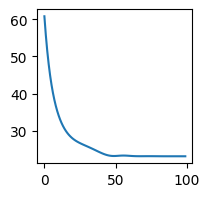

           Mean  Standard Deviation  5.5%  94.5%
Alpha     -0.00         0.15        -0.23  0.23 
Beta_logM -0.30         0.20        -0.61  0.02 
Sigma      0.88         0.14         0.64  1.11 


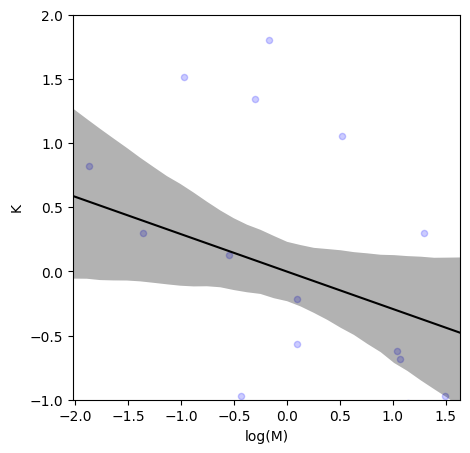

In [15]:
dtype = tf.float64
Log_Mdata = (np.log(mass) - np.log(mass).mean())/np.log(mass).std()
def log_posterior_K(alpha, bM, sigma, data):
  alpha_prior = tfd.Normal(tf.cast(0.,dtype), scale=0.2)
  bM_prior = tfd.Normal(loc=tf.cast(0.,dtype), scale=0.5)
  sigma_prior = tfd.Exponential(rate=tf.cast(1.0,dtype))
  mu = alpha + bM*Log_Mdata.values[:]
  K_likelihood = tfd.Normal(loc= mu, scale= sigma)
  return (
      alpha_prior.log_prob(alpha) +\
      bM_prior.log_prob(bM) +\
      sigma_prior.log_prob(sigma) +\
      tf.reduce_sum(K_likelihood.log_prob(data))
      )
def Mean_Quadratic_K(alpha, bM, sigma, data):
  losses = tfp.math.minimize(
      lambda: -log_posterior_K(alpha, bM, sigma, data),
      optimizer=tf.optimizers.Adam(learning_rate=0.05),
      num_steps=100)
  plt.subplots(figsize=(2,2))
  plt.plot(losses);
  plt.show()
  return (
      alpha.numpy(),
      bM.numpy(),
      sigma.numpy()
  )
def STD_Quadratic_K(alpha, bM, sigma, Func):
  dy = []
  d2y = []
  i = 0
  for Var in [alpha, bM, sigma]:
    with tf.GradientTape() as g:
      g.watch(Var)
      with tf.GradientTape() as gg:
        gg.watch(Var)
        y = -Func(alpha, bM, sigma)
      dy.append(gg.gradient(y, Var))
    d2y.append(g.gradient(dy[i], Var))
    i += 1
  return (
      ((1/d2y[0])**0.5 ).numpy(),
      ((1/d2y[1])**0.5 ).numpy(),
      ((1/d2y[2])**0.5 ).numpy(),
  )
log_posterior_K_forDerivation = lambda alpha,\
                                         bM,\
                                         sigma: log_posterior_K(alpha, bM, sigma, Kdata)

Mean_K = Mean_Quadratic_K(tf.Variable(tf.cast(1.,dtype)),
                      tf.Variable(tf.cast(1.,dtype)),
                      tf.Variable(tf.cast(1.,dtype)),
                      Kdata)
STD_K = STD_Quadratic_K(tf.convert_to_tensor(Mean_K[0]),
                    tf.convert_to_tensor(Mean_K[1]),
                    tf.convert_to_tensor(Mean_K[2]),
                    log_posterior_K_forDerivation)
N = 1000

alpha_est = tfd.Normal(loc=Mean_K[0], scale=STD_K[0]).sample(N).numpy()
bM_est = tfd.Normal(loc=Mean_K[1], scale=STD_K[1]).sample(N).numpy()
sigma_est = tfd.Normal(loc=Mean_K[2], scale=STD_K[2]).sample(N).numpy()

d = {}
Heading = {"Alpha":alpha_est,"Beta_logM":bM_est,"Sigma":sigma_est}
for i,est in enumerate(Heading.items()):
  d[i] = {'Mean': pd.Series(Mean_K[i], index=[est[0]]),
           'Standard Deviation': pd.Series(STD_K[i], index=[est[0]]),
           '5.5%': pd.Series(np.percentile(est[1],5.5), index=[est[0]]),
           '94.5%': pd.Series(np.percentile(est[1],94.5), index=[est[0]])}

Quadratic_K_est = pd.concat([pd.DataFrame(d[i]) for i in range(len(d))])
print(np.round(Quadratic_K_est, 2))

n = 30
xseq = np.linspace(Log_Mdata.min()-0.15,Log_Mdata.max()+0.15, n)
mu_pred = np.zeros((N,len(xseq)))

for i in range(len(xseq)):
  mu_pred[:,i] = alpha_est + bM_est*xseq[i]
mu_mean = np.mean(mu_pred, axis= 0)
mu_PI_89 = np.percentile(mu_pred, [5.5,94.5], axis= 0)

fig,ax = plt.subplots(figsize=(5,5))
ax.set(xlim=[xseq.min(),xseq.max()],ylim=[-1,2],ylabel="K",xlabel="log(M)")
ax.scatter(Log_Mdata, Kdata, s=20, alpha=0.2, facecolors='b', edgecolors = 'b', marker = "o")
ax.plot(xseq, mu_mean, '-k')
ax.fill_between(xseq, mu_PI_89[0,:], mu_PI_89[1,:], alpha=0.3, linewidth=0, color = 'k')